# Analyze r/loseit Challenge Data

Now we can read in the already cleaned file. If you don't have the cleaned data, you will need to run [Find and Clean Loseit Data](clean_loseit_challenge_data.ipynb) and [Inspect Loseit Data](inspect_loseit_challenge_data.ipynb).

In [94]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import datetime as dt
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import os
color = sns.color_palette()
from IPython.display import display, HTML
from collections import Counter
from matplotlib_venn import venn3
import itertools
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

We begin by loading in the dataset and look at the counts.

In [3]:
big_df = pd.read_csv('./data/outlier_fized_loseit_challenge_data.csv', index_col=0)
big_df['NSV Text'] = big_df['NSV Text'].astype(str).replace('nan', '')
age_df = pd.read_csv('./data/age_outlier_loseit_challenge_data.csv', index_col=0)
loss_df = pd.read_csv('./data/weight_loss_outlier_loseit_challenge_data.csv', index_col=0)

In [4]:
# here we are going to set some of the plotting parameters that we will use for all of the plots.
sns.set(style="ticks",context='talk')
sns.set_palette('colorblind')

## Partipicant Stats

### Username

From partipicating in a few different challenges, there are many people who have done multiple challenges. I want to begin by looking at how many have done more than one challenge, and who has partipicated in the most challenges.

In [50]:
duplicate_df = big_df[big_df.duplicated(subset=['Username'])]
no_duplicate_df = big_df[~big_df.duplicated(subset=['Username'], keep=False)]
print(f'multiple challenges: {len(duplicate_df.Username.value_counts())} and single challenge: {len(no_duplicate_df.Username.value_counts())}')

multiple challenges: 1288 and single challenge: 4397


So we can see that there have been 1288 people who have participated in more than one challenge (and using the same username) and 4397 people who have only participated in a single challenge so far -- again this doesn't account for people who sign-up using multiple accounts.

In [76]:
(duplicate_df.Username.value_counts() + 1).head(15)    # because the first occurance was not counted

bugs_bunny01           9
axecutable             9
BlackAnemones          9
Lovellama              9
MrBad-Example          8
shd244                 8
Radiant_Indignation    8
kmrbriscoe             8
unreuly                8
BethLynn85             8
soahtree               8
thosethighstho         7
kovvu_kariginchu       7
GetMotivatedNow        7
bella_ray              7
Name: Username, dtype: int64

In [66]:
num_challenges = big_df.Username.value_counts()

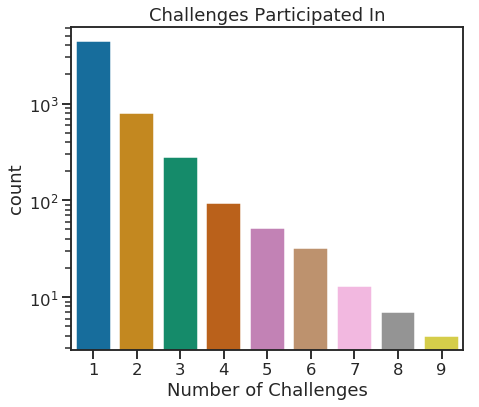

In [63]:
f, ax = plt.subplots(figsize=(7, 6))
sns.countplot(num_challenges)
ax.set_yticks([])
ax.set_yscale('log')
ax.set_xlabel('Number of Challenges')
ax.set_title('Challenges Participated In')
f.tight_layout()
f.savefig('./figures/challenges_partipicated_in.png', dpi=400)

Comment about the number of challenges that people partipicate in.

### Gender

Let's start by looking at the gender distribution of r/loseit partipicants.

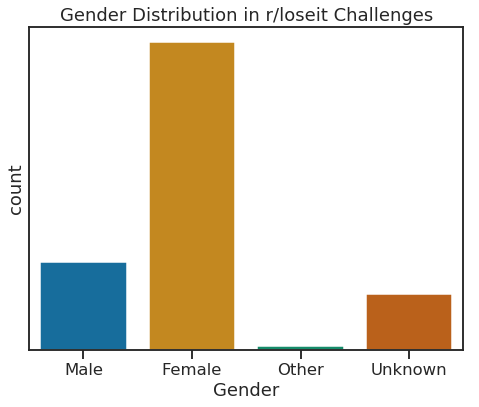

In [37]:
f, ax = plt.subplots(figsize=(7, 6))
sns.countplot(x='Gender', data=big_df)
ax.set_yticks([])
ax.set_title('Gender Distribution in r/loseit Challenges')
f.tight_layout()
f.savefig('./figures/gender_bar_chart.png', dpi=400)

In [38]:
print(f' Males: {(100 * len(big_df[big_df.Gender == "Male"])/len(big_df)):.2f}% ,'
      f' Females: {(100 * len(big_df[big_df.Gender == "Female"])/len(big_df)):.2f}%,'
      f' Other: {(100 * len(big_df[big_df.Gender == "Other"])/len(big_df)):.2f}%,'
      f' Unknown: {(100 * len(big_df[big_df.Gender == "Unknown"])/len(big_df)):.2f}%')

 Males: 19.33% , Females: 67.44%, Other: 0.87%, Unknown: 12.37%


Looking that this plot it is pretty clear that loseit challenges have a very large gender imbalance. Around 67% of the partipicants in the challenges are women, 19% are male, 12% are unknown, and almost 1% of partipicants identify as other. Because there is such a large imbalance, for most of my analysis I will try and look at how the numbers vary between gender -- if they do at all.

### Age

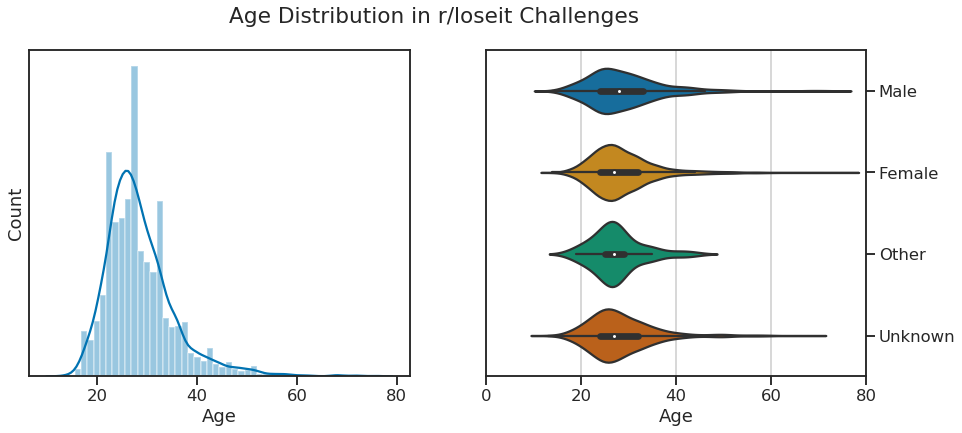

In [80]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 6))

sns.distplot(age_df['Age'], ax=ax1)
ax1.set_yticks([])
ax1.set_ylabel('Count')

sns.violinplot(x='Age', y="Gender", data=age_df, ax=ax2)
ax2.xaxis.grid(True)
ax2.set(ylabel="")
ax2.set_xlim([0, 80])
# ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

# ax2.set_title('Age Distribution in r/loseit Challenges')
f.suptitle('Age Distribution in r/loseit Challenges')

f.savefig('./figures/violin_gender_age.png', dpi=400)

In [81]:
print(f'most common: {Counter(age_df["Age"]).most_common(1)}, average: {age_df["Age"].mean():.1f}, yongest: {age_df["Age"].min()}, oldest: {age_df["Age"].max()}')

most common: [(26.0, 647)], average: 28.6, yongest: 13.0, oldest: 76.0


Looking at the age distributions, we find that there is a large peak at the most common age 26. The oldest partipicant is 76 and the youngest has been 13. Looking the distributions seperated by gender, we see that there us not a huge difference between them.

One thing of note, is that there are many people who have done multiple challenes. These results might change slightly if we were only look at the distributions for unique usernames.

In [82]:
no_dup_age_df = age_df[~age_df.duplicated(subset=['Username'])]

In [83]:
print(f'most common: {Counter(no_dup_age_df["Age"]).most_common(1)}, '
      f'average: {no_dup_age_df["Age"].mean():.1f}, yongest: {no_dup_age_df["Age"].min()}, '
      f'oldest: {no_dup_age_df["Age"].max()}')

most common: [(26.0, 470)], average: 28.4, yongest: 13.0, oldest: 76.0


So we find that even with removing duplicate usernames, the most common age of partipicants is still 26.

### Height

The next piece of information that I want to look at is the height distribution.

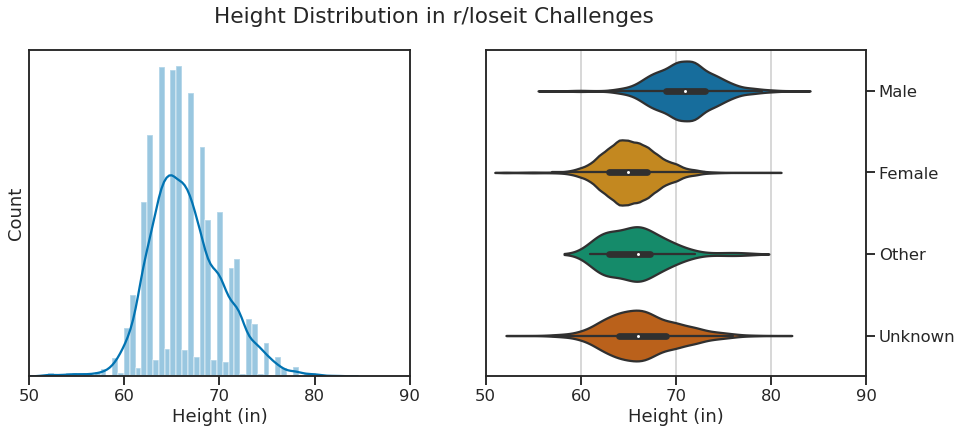

In [87]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 6))

sns.distplot(big_df['Height'], ax=ax1)
ax1.set_yticks([])
ax1.set_ylabel('Count')
ax1.set_xlim([50, 90])
ax1.set_xlabel('Height (in)')

sns.violinplot(x='Height', y="Gender", data=big_df, ax=ax2)
ax2.xaxis.grid(True)
ax2.set(ylabel="")
ax2.set_xlim([50, 90])
ax2.set_xlabel('Height (in)')
ax2.yaxis.tick_right()

# ax2.set_title('Age Distribution in r/loseit Challenges')
f.suptitle('Height Distribution in r/loseit Challenges')

f.savefig('./figures/violin_gender_height.png', dpi=400)

In [89]:
print(f'average: {big_df["Height"].mean():.1f} in, shortest: {big_df["Height"].min()} in, '
      f'tallest: {big_df["Height"].max()} in')

average: 66.5 in, shortest: 52.0 in, tallest: 82.6 in


### NSV and Tracking

Next, I want to look at the proportion of those who give links to either fitness or food trackers and provide a NSV.

In [112]:
print(f"Has NSV: {big_df['Has NSV'].sum()/len(big_df) * 100:.2f}")
print(f"Gives activity tracker: {big_df['Has Activity Tracker'].sum()/len(big_df) * 100:.2f}")
print(f"Gives food tracker: {big_df['Has Food Tracker'].sum()/len(big_df) * 100:.2f}")

Has NSV: 79.96
Gives activity tracker: 21.08
Gives food tracker: 58.53


In [106]:
# making sets for a venn diagram
nsv = big_df['Has NSV'] # A
at = big_df['Has Activity Tracker']# B
big_df['Has Food Tracker'] # C

Abc = ((big_df['Has Activity Tracker'] + big_df['Has Food Tracker'])[big_df['Has NSV'] == 1] == 0).astype(int).sum()
aBc = ((big_df['Has NSV'] + big_df['Has Food Tracker'])[big_df['Has Activity Tracker'] == 1] == 0).astype(int).sum()
ABc = ((big_df['Has NSV'] + big_df['Has Activity Tracker'])[big_df['Has Food Tracker'] == 0] == 2).astype(int).sum()
abC = ((big_df['Has NSV'] + big_df['Has Activity Tracker'])[big_df['Has Food Tracker'] == 1] == 0).astype(int).sum()
AbC = ((big_df['Has NSV'] + big_df['Has Food Tracker'])[big_df['Has Activity Tracker'] == 0] == 2).astype(int).sum()
aBC = ((big_df['Has Activity Tracker'] + big_df['Has Food Tracker'])[big_df['Has NSV'] == 0] == 2).astype(int).sum()
ABC = ((big_df['Has Activity Tracker'] + big_df['Has Food Tracker'] + big_df['Has NSV']) == 3).astype(int).sum()
abc = ((big_df['Has Activity Tracker'] + big_df['Has Food Tracker'] + big_df['Has NSV']) == 0).astype(int).sum()

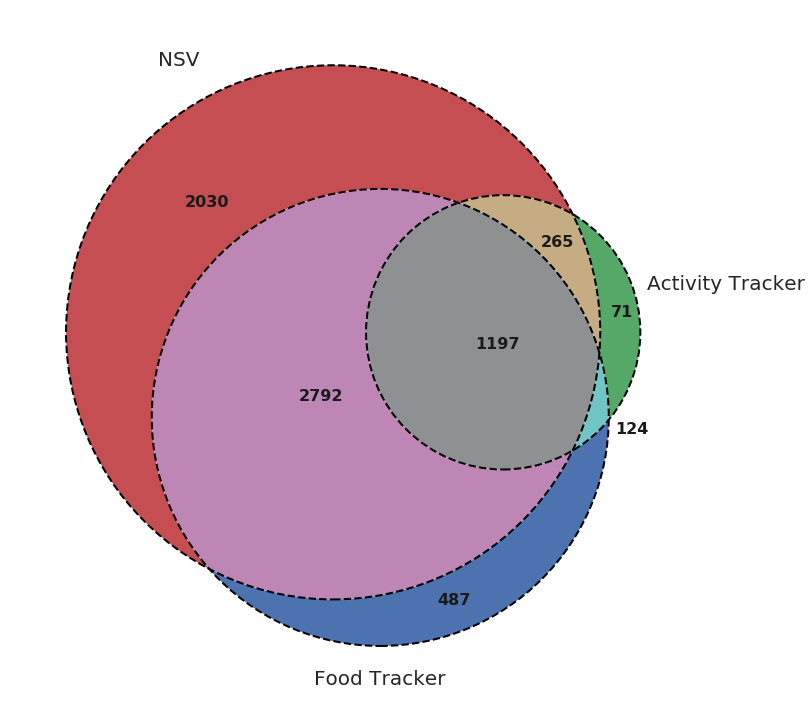

In [207]:
venn_colors = sns.color_palette()[::-1]
venn_labels = ["".join(seq) for seq in itertools.product("01", repeat=3)][1:]

f, ax = plt.subplots(figsize=(10,10))

v = venn3(subsets=(Abc, aBc, ABc, abC, AbC, aBC, ABC), set_labels=('NSV', 'Activity Tracker', 'Food Tracker'), alpha=1)
venn3_circles(subsets=(Abc, aBc, ABc, abC, AbC, aBC, ABC), linestyle='dashed', linewidth=2)

# setting the colors to match the color palette used in other plots
for i, label in enumerate(venn_labels):
    v.get_label_by_id(label).set_color(venn_colors[i])
    
# shifting labels to get centered text
v.get_label_by_id("011").set_x(.52)
v.get_label_by_id("011").set_y(-.13)
v.get_label_by_id("110").set_x(.37)
v.get_label_by_id("111").set_x(.25)
v.get_label_by_id("111").set_y(.04)
v.get_label_by_id("010").set_x(.5)

v.set_labels[1].set_x(.55)
v.set_labels[1].set_y(.15)

# font size changes
for text in v.set_labels:
    text.set_fontsize(20)
    
for text in v.subset_labels:
    text.set_fontsize(16)
    text.set_color('k')
    text.set_fontweight('bold')

f.tight_layout()
f.savefig('./figures/nsv_activity_food_tracker_venn_diagram.png', dpi=400)

In [109]:
print(f"number of people who don't give any info: {abc}, {(abc/len(big_df) * 100):.2f}%")

number of people who don't give any info: 893, 11.36%


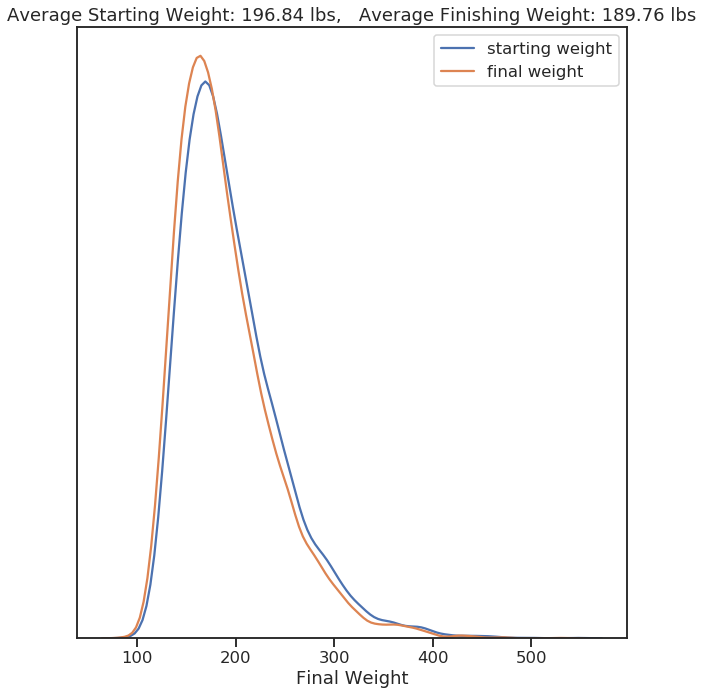

In [81]:
plt.figure(figsize=(10,10))
ax = sns.distplot(loss_df['Starting Weight'], hist=False, label='starting weight')
ax = sns.distplot(loss_df['Final Weight'], hist=False, label='final weight')
ax.set_yticks([])
ax.set_title(f'Average Starting Weight: {loss_df["Starting Weight"].mean():.2f} lbs,   Average Finishing Weight: {loss_df["Final Weight"].mean():.2f} lbs')
ax.legend()
plt.tight_layout()
plt.savefig('./figures/starting_final_weight.png', dpi=400)

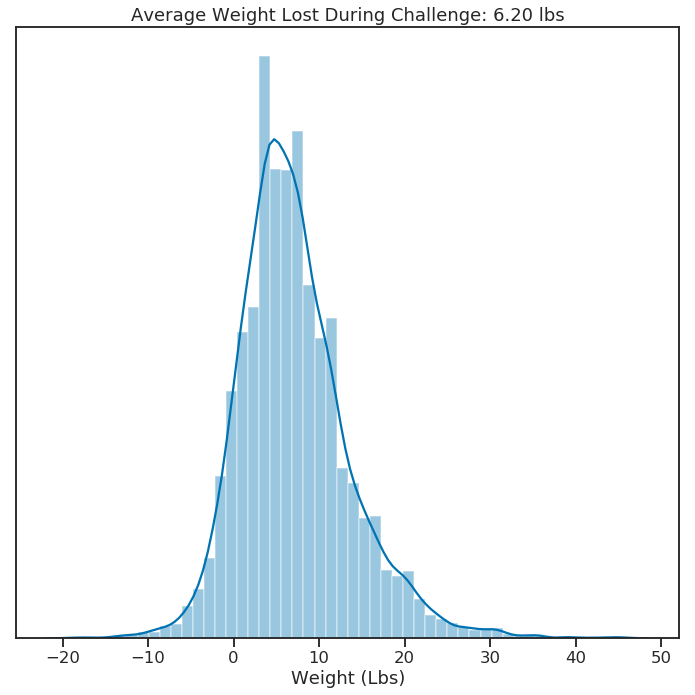

In [138]:
plt.figure(figsize=(10,10))
ax = sns.distplot(loss_df['Total Challenge Loss'])
ax.set_xlabel('Weight (Lbs)')
ax.set_title(f'Average Weight Lost During Challenge: {loss_df["Total Challenge Loss"].median():.2f} lbs')
ax.set_yticks([])
plt.tight_layout()
plt.savefig('./figures/average_weight_lost.png', dpi=400)

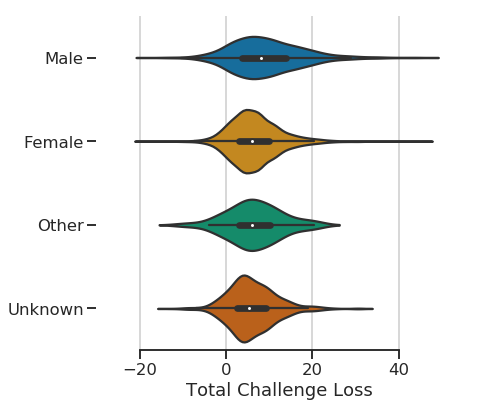

In [90]:
f, ax = plt.subplots(figsize=(7, 6))

sns.violinplot(x="Total Challenge Loss", y="Gender", data=loss_df)

ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set_xlim([-30, 55])
sns.despine(trim=True, left=True)
f.tight_layout()
f.savefig('./figures/violin_gender_weight_lost.png', dpi=400)

In [103]:
Counter(big_df['NSV Text'].str.lower()).most_common(50)

[('', 1575),
 ('fit into old clothes', 43),
 ('run a 5k', 34),
 ('run 5k', 23),
 ('finish c25k', 14),
 ('run 10k', 13),
 ('run a 10k', 10),
 ('go down a pant size', 10),
 ('run a mile', 9),
 ('fit into old jeans', 8),
 ('complete c25k', 7),
 ('fit into my old jeans', 6),
 ('drop a pant size', 6),
 ('start c25k', 6),
 ('fit into old clothes ', 5),
 ('lose a pant size', 5),
 ('fit into an old dress', 5),
 ('run faster', 5),
 ('feel better', 5),
 ('finish c25k!', 5),
 ('clothes fitting better', 5),
 ('consistency', 5),
 ('visible abs', 5),
 ('go down a pants size', 5),
 ('fit into clothes better', 5),
 ('200', 5),
 ('run a 5k without stopping', 5),
 ('have more energy', 4),
 ('fit into old clothes.', 4),
 ('size 12 jeans!', 4),
 ('run 5k without stopping', 4),
 ('run for longer distances', 4),
 ('start running again', 4),
 ('run a 5k ', 4),
 ('fitting into my old clothes', 4),
 ('log every day', 4),
 ('sub 30 minute 5k', 4),
 ('size 8 jeans', 4),
 ('feel more confident', 4),
 ('run 5km', 

In [93]:
# list of text documents
text = ["The quick brown fox jumped over the lazy dog."]
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(big_df['NSV Text'])
# summarize
print( list(vectorizer.vocabulary_.items())[:10] )
print("\n vocabulary size {}".format(len(vectorizer.vocabulary_)))
all_words = vectorizer.get_feature_names()
hot_words = vectorizer.fit_transform(big_df['NSV Text']).toarray()

[('finish', 1209), ('the', 2767), ('10k', 20), ('under', 2905), ('44mins', 215), ('fit', 1218), ('into', 1550), ('next', 1948), ('size', 2519), ('down', 1013)]

 vocabulary size 3100


In [94]:
freq = hot_words.sum(axis=0)

In [95]:
words_df = pd.DataFrame(freq)

In [96]:
words_df = words_df.T

In [97]:
words_df.columns = all_words

In [98]:
words_df[words_df.columns[words_df.loc[0].argsort()][::-1]].T.head(20)

,0
to,1593
my,1446
fit,1334
into,1208
in,865
size,752
the,685
run,617
and,581
clothes,466


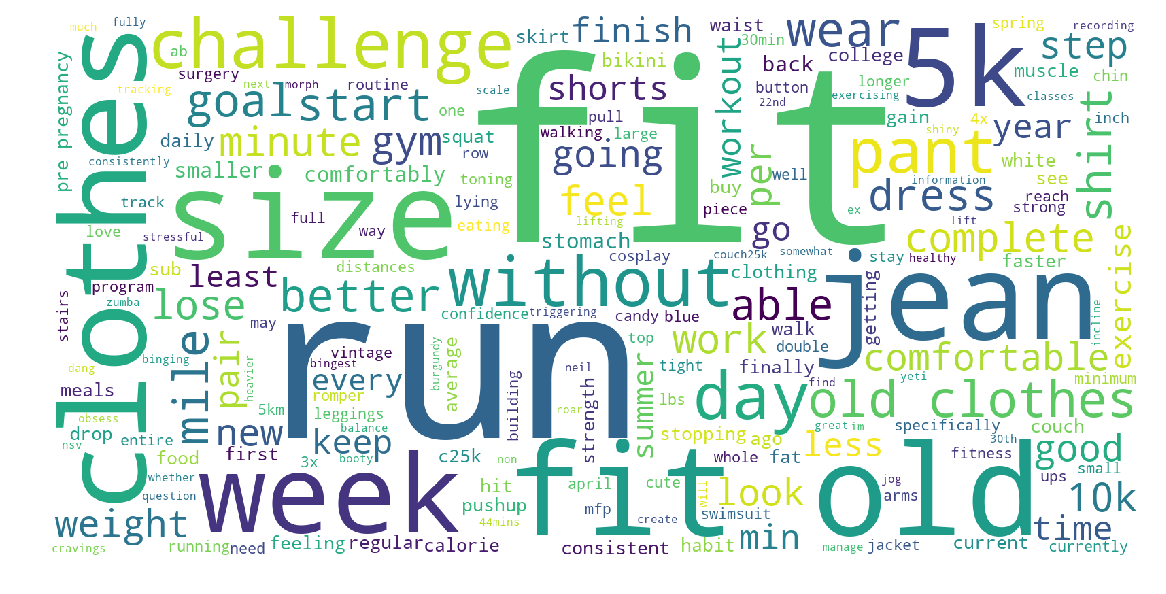

In [104]:
# Create and generate a word cloud image:
num_nsv = 300
text = " ".join(review for review in big_df['NSV Text'].head(num_nsv))
text = text.lower()
wordcloud = WordCloud(background_color="white", width=1600, height=800).generate(text)

# Display the generated image:
plt.figure( figsize=(20,10), facecolor='w')
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig(f'./figures/nsv_{num_nsv}_wordcloud.png', facecolor='w', bbox_inches='tight')

In [105]:
text

'finish the 10k under 44mins fit into next size down jeans run more reach week 7 in c25k walk/run at least 3x a week  run longer distances, lift heavier - be a yeti!! roar!!!!!!!!!!! start going to the gym. finish the challenge for once complete couch25k! fit an l t-shirt  stay on track i would love to be able to comfortable cosplay april o’neil manage food cravings and habits  toning up somewhat! fit into old pants.  jog 30 min without stopping my nsv for this challenge will be to not obsess to much about the scale and calories.  fit into old clothes workout a minimum of 3 days per week every week consistently work out start running and lifting run 5k in <35 mins find balance and create consistent healthy eating habits be able to do a regular (non-incline) pushup wear the booty shorts start going to workout classes have no question whether im at my surgery weight or not. surgery is on may 22nd. keep my binging at a minimum during a stressful time at work, tracking the bingest and reco

In [102]:
texts=["dog cat fish","dog cat cat","fish bird", 'bird']
cv = CountVectorizer()
cv_fit=cv.fit_transform(texts)

print(cv.get_feature_names())
print(cv_fit.toarray())
#['bird', 'cat', 'dog', 'fish']
#[[0 1 1 1]
# [0 2 1 0]
# [1 0 0 1]
# [1 0 0 0]]
print(cv_fit.toarray().sum(axis=0))
#[2 3 2 2]

['bird', 'cat', 'dog', 'fish']
[[0 1 1 1]
 [0 2 1 0]
 [1 0 0 1]
 [1 0 0 0]]
[2 3 2 2]


In [103]:
# check these out 
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
def tokenize_normalize(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ", tweet)
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [104]:
# the sklearn vectorizer scans our corpus, build the vocabulary, and changes text into vectors
vectorizer = CountVectorizer(
    strip_accents='unicode', 
    lowercase=True, 
    tokenizer=tokenize_normalize,
    min_df=2,
    ngram_range=(1,4),  # you may want to try 2 grams. The vocab will get very large though
)
# first learn the vocabulary
vectorizer.fit(big_df['NSV Text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 4), preprocessor=None, stop_words=None,
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_normalize at 0x7fdb0b4dc730>,
        vocabulary=None)

In [105]:
# take a peek at the vocabulary learnt. We have the terms and the counts
print( list(vectorizer.vocabulary_.items())[:10] )
print("\n vocabulary size {}".format(len(vectorizer.vocabulary_)))

[('k', 1120), ('min', 1443), ('k min', 1131), ('next', 1534), ('size', 1987), ('jean', 1077), ('next size', 1538), ('size jean', 2002), ('c', 290), ('c k', 291)]

 vocabulary size 2624
